# Notebook 6  - Machine Learning Models for Time Series Forecasting

`Yesterday is gone. Tomorrow has not yet come. We have only today. Let us begin.
-Mother Theresa`

---

## Notebook Outline

- Machine Learning Models for Time Series Forecasting

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from pandas.plotting import register_matplotlib_converters
from IPython.display import display
from tsa_functions import *

register_matplotlib_converters()
sns.set_style('darkgrid')

np.set_printoptions(precision=2)
pd.set_option('precision', 2)

ModuleNotFoundError: No module named 'tsa_functions'

---

## Machine Learning Models for Time Series Forecasting

In this notebook, we will build a methodology for using machine learning models for time series forecasting.

---

#### Example: Global Surface Summary of the Day - Manila

Data is taken from the National Centers for Environmental Information (NCEI), which is part of the National Oceanic and Atmospheric Administration (NOAA) under the U.S. Department of Commerce. Specifically, we will be using the Global Surface Summary of Day Data (GSOD) for Station 984250 - Manila covering the years from 1990 to 2020 (31 years).

| Features | Description |
| --- | --- |
| YEARMODA | Date |
| TEMP | Mean temperature for the day in Fahrenheit |
| MAX | Max temperature for the day in Fahrenheit |
| MIN | Min temperature for the day in Fahrenheit |
| WDPD | Mean wind speed for the day in knots |
| MXSPD | Max sustained wind speed for the day in knots |
| PRCP | Total precipitation reported during the day in inches |


<b>IMPORTANT NOTES</b>:

- Missing values have already been recoded and imputed (linearly, so they are bad)
- Leap days have been removed

In [5]:
df = pd.read_csv('special_datasets/gsod_manila_1990_2020.csv')
df.index = pd.to_datetime(df.YEARMODA)
del df['YEARMODA']
df

,TEMP,MAX,MIN,WDSP,MXSPD,PRCP
YEARMODA,,,,,,
1990-01-01,79.0,84.6,74.7,2.9,5.8,0.00
1990-01-02,81.1,85.8,73.4,2.9,7.8,0.00
1990-01-03,80.4,85.1,75.6,4.9,11.7,0.00
1990-01-04,78.2,84.2,74.3,3.3,9.7,0.00
1990-01-05,79.7,86.4,73.0,3.9,9.7,0.00
...,...,...,...,...,...,...
2020-12-27,75.9,77.4,75.0,3.6,7.8,1.14
2020-12-28,82.7,87.8,73.4,3.6,7.8,0.00
2020-12-29,83.0,91.6,78.6,4.4,7.8,0.16


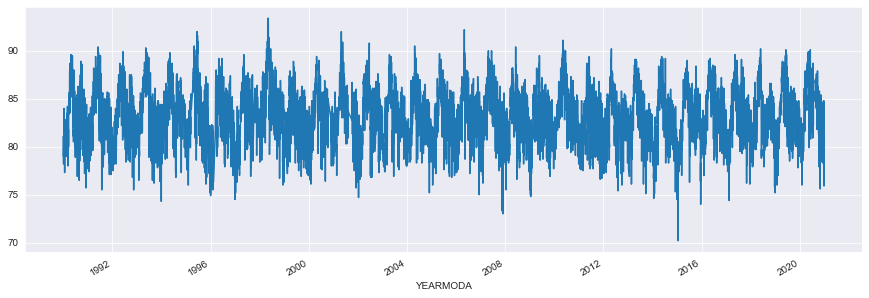

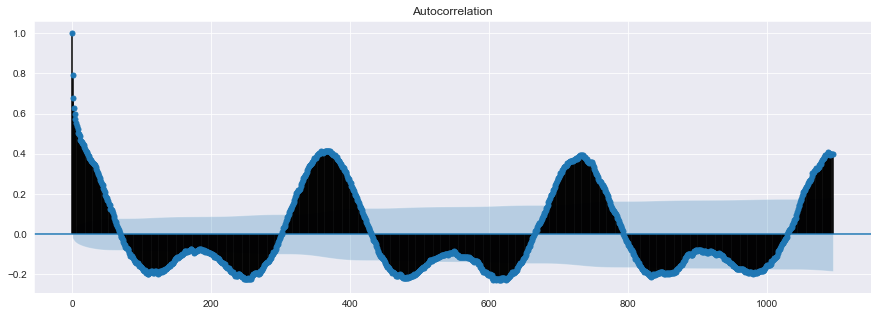

In [6]:
df.TEMP.plot(figsize=(15,5))
plt.show()

fig, ax = plt.subplots(figsize=(15,5))
sm.graphics.tsa.plot_acf(df.TEMP, lags=365*3, ax=ax)
plt.show()

### Time Series Forecasting as a Regression Problem

In a previous notebook, we briefly discussed how one can use classic regression models on time series data.

To do this, we first need to transform the data into a supervised learning dataset.

In other words, we need to create a new dataset consisting of $X$ and $Y$ variables, where $X$ refers to the features and $Y$ refers to the targets.

### Autoregression

<b><i>Autoregression</b></i> is the idea of using lagged values of a random variable as predictors for future observations. 

For example, the classic autoregressive (AR) model is formulated as:

\begin{align*}
    X_{t} &= \beta_0 + \sum_{i=1}^{p} \beta_{i} X_{t-i} + \varepsilon_t
\end{align*}

More generally, the data generating process can be written as:

\begin{align*}
    X_{t} &= f\left(X_{t-1}, X_{t-2}, \ldots\right)
\end{align*}

where $f$ may be some linear or non-linear function. 

In this notebok, we will be using machine learning models to estimate $f$.

### Lookback Window

To create the new $(X,Y)$ dataset, we first need to decide what the $X$ features are. 

For the moment, let's ignore any exogenous variables. In this case, what determines the $X$s is how far we <i>lookback</i>. For example, this corresponds to the $(p,d,q)$ parameters in the classic ARIMA formulaton.

In general, we can treat the lookback as a hyperparameter, which we will call the <i>window size</i>. Note that hyperparameters can either be optimized for or heuristically selected.

<i>Advanced note:</i> Technically, we could build an entire methodology for feature engineering $X$s.

### One-Step Forecasting

Let's build a model for making one-step forecasts.

In this example, we'll use observations from 2019. For testing, we will hold out the month of December (that's 31 data points).

Thus, to test our model, we will be generating <u>31 one-step forecasts</u>!

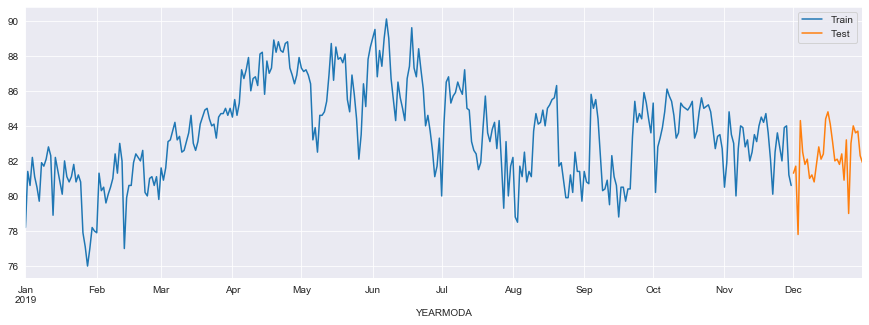

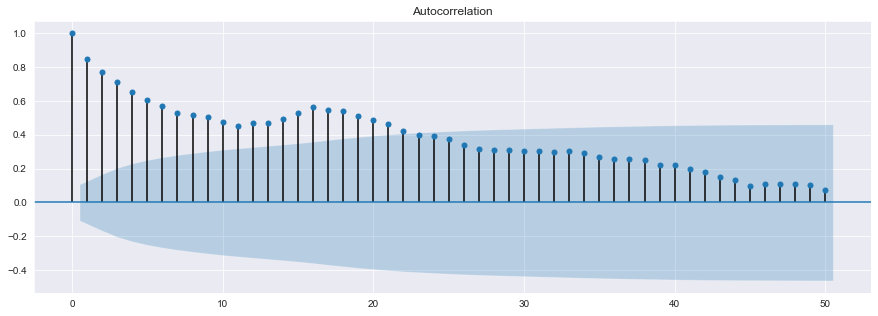

,TEMP,MAX,MIN,WDSP,MXSPD,PRCP
YEARMODA,,,,,,
2019-01-01,78.2,85.1,72.7,3.1,5.8,0.83
2019-01-02,81.4,88.7,73.4,3.4,5.8,0.09
2019-01-03,80.6,84.2,75.7,3.9,7.8,0.00
2019-01-04,82.2,89.2,75.9,5.3,7.8,0.00
2019-01-05,81.1,90.0,74.5,5.6,9.7,0.00
...,...,...,...,...,...,...
2019-12-27,84.0,92.3,77.9,3.9,5.8,0.00
2019-12-28,83.6,90.5,78.3,4.1,11.7,0.00
2019-12-29,83.7,89.2,77.9,4.7,11.7,0.00


In [7]:
n = 365
test_size = 31

df_sample = df.iloc[-n*2:-n, :]
ts_train = df_sample.TEMP[:-test_size]
ts_test = df_sample.TEMP[-test_size:]

ax = ts_train.plot(figsize=(15,5), label='Train')
ts_test.plot(ax=ax, label='Test')
ax.legend()
plt.show()

fig, ax = plt.subplots(figsize=(15,5))
sm.graphics.tsa.plot_acf(ts_train, lags=50, ax=ax)
plt.show()

display(df_sample)

In [8]:
def train_test_split(df_data, w, h, test_size, features):

    ### Train-Test split from DataFrame ###
    
    ### Exogenous Variables ###
    feat_len = len(features)
    df_series = df_data[features]
    
    split_time = df_series.shape[0] - test_size
    
    df_train = df_series.iloc[:split_time, :]
    df_test = df_series.iloc[split_time - w:, :]

    return df_train, df_test

def create_xy(series, label, w, h, shuffle=False):
    
    ### Create (X,Y) from DataFrame ####
    
    x = []
    y = []
    for i in range(series.shape[0]):
        if series.iloc[(i + w):(i + w + h), :].shape[0] < h:
            break
        x.append(series.iloc[i:(i + w), :])
        y.append(series.iloc[(i + w):(i + w + h), :][label])
    x = np.dstack(x)
    y = np.dstack(y)
    
    # Reshape x to (samples, features, lookback)
    x = np.swapaxes(x, 0, 2)
    
    # Reshape x to (samples, horizon)
    y = np.swapaxes(y, 0, 2)
    y = y[:, :, 0]
    
    return x,y

In [19]:
### HYPERPARAMETERS ###
w = 7
h = 1
test_size = 31
target = ['TEMP']
features = ['TEMP']
# features = ['TEMP', 'MAX', 'MIN', 'WDSP', 'MXSPD', 'PRCP']

df_train, df_test = train_test_split(df_sample, w, h, test_size, features)

print('Train Series Shape:', df_train.shape)
print(' Test Series Shape:', df_test.shape)

### X,Y TRAIN SUPERVISED CREATION ###
train_x, train_y = create_xy(df_train, target[0], w, h, shuffle=False)

### X,Y TEST SUPERVISED CREATION ###
test_x, test_y = create_xy(df_test, target[0], w, h, shuffle=False)

print('     Train X Shape:', train_x.shape)
print('     Train Y Shape:', train_y.shape)

print('      Test X Shape:', test_x.shape)
print('      Test Y Shape:', test_y.shape)

Train Series Shape: (334, 1)
 Test Series Shape: (38, 1)
     Train X Shape: (327, 1, 7)
     Train Y Shape: (327, 1)
      Test X Shape: (31, 1, 7)
      Test Y Shape: (31, 1)


In [20]:
### Flatten Features ###
train_x = train_x.reshape((train_x.shape[0], train_x.shape[1]*train_x.shape[2]))
test_x = test_x.reshape((test_x.shape[0], test_x.shape[1]*test_x.shape[2]))

print('     Train X Shape:', train_x.shape)
print('     Train Y Shape:', train_y.shape)

print('      Test X Shape:', test_x.shape)
print('      Test Y Shape:', test_y.shape)

     Train X Shape: (327, 7)
     Train Y Shape: (327, 1)
      Test X Shape: (31, 7)
      Test Y Shape: (31, 1)


### LightGBM

The first ML model we'll look at is [`LightGBM`](https://lightgbm.readthedocs.io/en/latest/), a gradient boosting framework that uses tree-based learning algorithms designed for "speed and efficiency".

In [21]:
import lightgbm as lgb

model = lgb.LGBMRegressor()

model.fit(train_x, train_y.ravel()) # We have to flatten train_y

forecast_lgbm = model.predict(test_x)

     Naive MAE: 1.3065 Celsius
  LightGBM MAE: 1.3177 Celsius


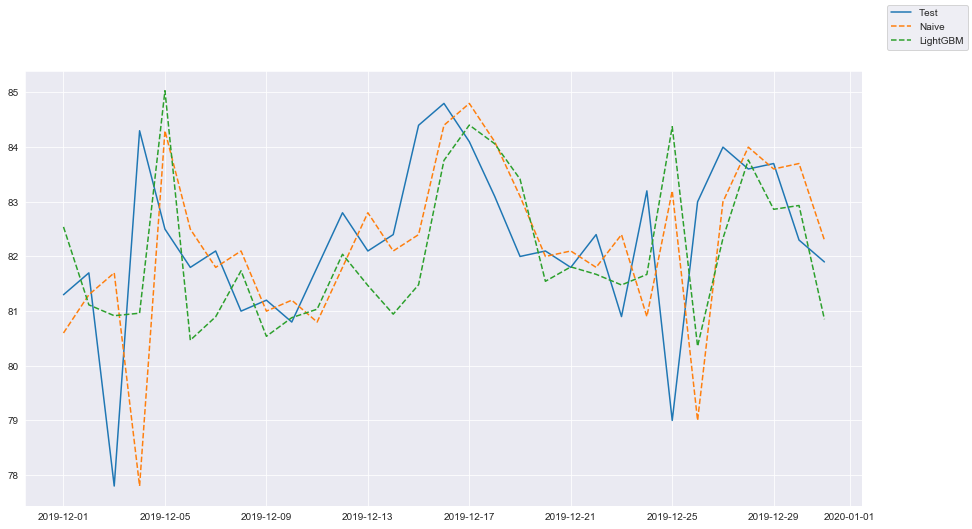

In [23]:
# Instead of iteratively using the naivef() function, i'll use array slicing to create the forecasts
forecast_naive = df_sample.TEMP[-test_size-1:-1].to_numpy()

print('     Naive MAE: %.4f Celsius' % mae(ts_test, forecast_naive))
print('  LightGBM MAE: %.4f Celsius' % mae(ts_test, forecast_lgbm))

ax = plt.figure(figsize = (15,8))
plt.plot(ts_test, label='Test')
plt.plot(ts_test.index, forecast_naive, linestyle = '--', label='Naive')
plt.plot(ts_test.index, forecast_lgbm, linestyle = '--', label='LightGBM')
ax.legend()
plt.show()

Let's check the residuals of our LightGBM model.

In [17]:
fitted = model.predict(train_x)

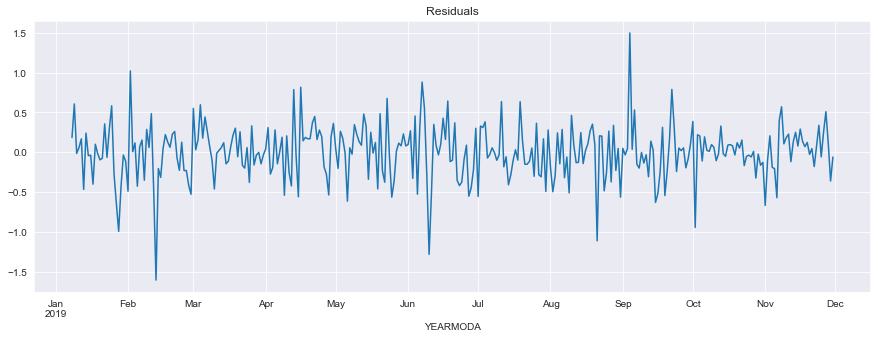

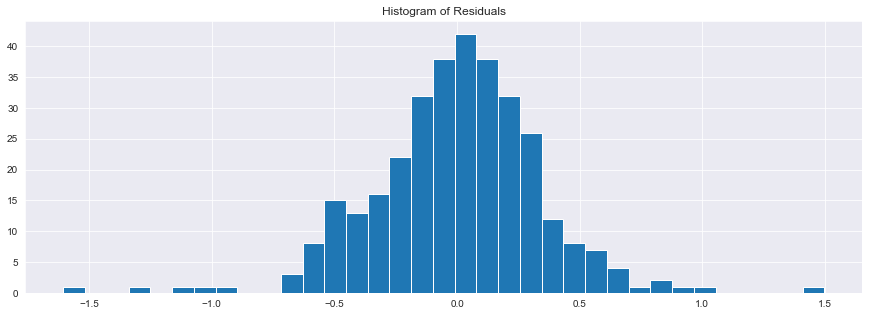

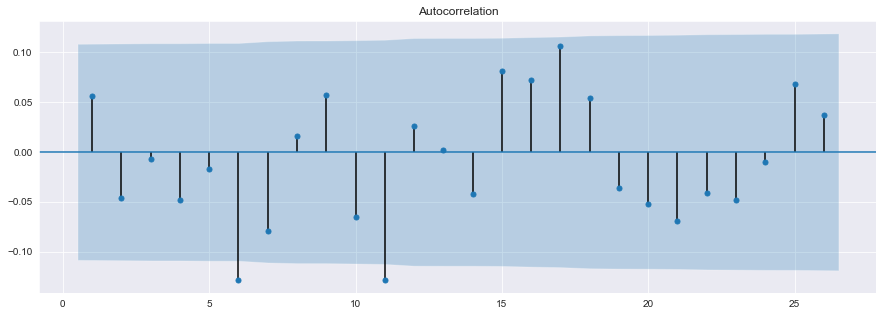

In [18]:
residuals = ts_train[w:] - fitted

ax = residuals.plot(figsize=(15,5))
ax.set_title('Residuals')
ax.autoscale()
plt.show()

ax = residuals.hist(figsize=(15,5), bins=35)
ax.set_title('Histogram of Residuals')
plt.show()

fig, ax = plt.subplots(figsize=(15,5))
sm.graphics.tsa.plot_acf(residuals, zero=False, ax=ax)
plt.show()

### K-Fold Cross-Validation for Autoregression

[Bergmeir, Hyndman and Koo (2015).](https://robjhyndman.com/publications/cv-time-series/) showed that you can actually use k-fold cross-validation for purely autoregressive models as long as the models considered have uncorrelated errors.

Let's optimize our lookback window by using k-fold CV and minimizing `MAE`.

In [12]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold

windows = range(1, 22)

results = []
names = []
for w in windows:
    
    h = 1
    test_size = 31
    target = ['TEMP']
    features = ['TEMP']

    df_train, df_test = train_test_split(df_sample, w, h, test_size, features)

    ### X,Y TRAIN SUPERVISED CREATION ###
    train_x, train_y = create_xy(df_train, target[0], w, h, shuffle=False)

    ### Flatten Features ###
    train_x = train_x.reshape((train_x.shape[0], train_x.shape[1]*train_x.shape[2]))
    
    cv = RepeatedKFold(n_splits = 10, n_repeats = 3, random_state = 1)
    scores = cross_val_score(lgb.LGBMRegressor(), train_x, train_y.ravel(), scoring = 'neg_mean_absolute_error', cv = cv, n_jobs = -1)
    results.append(scores)
    names.append(w)
    print('%4d --- MAE: %.4f (%.4f)' % (w, np.mean(scores), np.std(scores)))

   1 --- MAE: -1.1349 (0.1265)
   2 --- MAE: -1.1911 (0.1426)
   3 --- MAE: -1.2082 (0.1756)
   4 --- MAE: -1.2030 (0.1514)
   5 --- MAE: -1.2423 (0.1776)
   6 --- MAE: -1.2428 (0.1566)
   7 --- MAE: -1.2547 (0.1601)
   8 --- MAE: -1.2536 (0.1513)
   9 --- MAE: -1.2338 (0.1457)
  10 --- MAE: -1.2358 (0.1571)
  11 --- MAE: -1.2475 (0.1587)
  12 --- MAE: -1.2633 (0.1360)
  13 --- MAE: -1.2596 (0.1741)
  14 --- MAE: -1.2741 (0.1648)
  15 --- MAE: -1.2629 (0.1564)
  16 --- MAE: -1.2760 (0.1609)
  17 --- MAE: -1.2069 (0.1405)
  18 --- MAE: -1.1904 (0.1291)
  19 --- MAE: -1.1872 (0.1395)
  20 --- MAE: -1.1970 (0.1587)
  21 --- MAE: -1.1828 (0.1219)


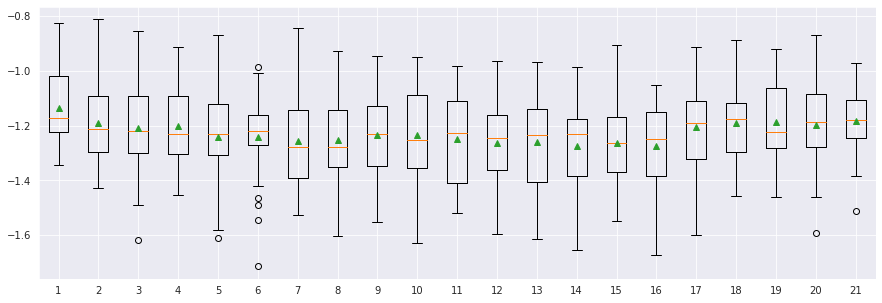

In [13]:
fig, ax = plt.subplots(figsize=(15,5))  
plt.boxplot(results, labels = names, showmeans = True)
plt.show()

### Multi-Step Forecasting

Suppose we were interested in forecasting the next $n$-days instead of just the next day.

There are several strategies we can use to do this:

1. Recursive Forecasting


2. Direct Forecasting


3. Single-Shot Forecasting


Check [Bontempi et al. (2012)](https://link.springer.com/chapter/10.1007/978-3-642-36318-4_3) for more complex combos.

#### Recursive Forecasting

In recursive forecasting, we first train a one-step model then generate a multi-step forecast by recursively feeding our predictions back into the model.

In [14]:
w = 1
h = 1
test_size = 31
target = ['TEMP']
features = ['TEMP']

df_train, df_test = train_test_split(df_sample, w, h, test_size, features)

train_x, train_y = create_xy(df_train, target[0], w, h, shuffle=False)
test_x, test_y = create_xy(df_test, target[0], w, h, shuffle=False)

train_x = train_x.reshape((train_x.shape[0], train_x.shape[1]*train_x.shape[2]))
test_x = test_x.reshape((test_x.shape[0], test_x.shape[1]*test_x.shape[2]))
test_y = test_y.ravel()    # We have to flatten test_y
train_y = train_y.ravel()  # We have to flatten train_y

model = lgb.LGBMRegressor().fit(train_x, train_y) 

In [15]:
forecast_recursive = []
x = test_x[:1, :].copy() # Must copy to avoid memory warnings

for i in range(test_size):
    y_hat = model.predict(x)
    x = np.append(x[:1, :-1], y_hat).reshape(1, -1)
    forecast_recursive.append(y_hat) 
    
forecast_recursive = np.concatenate(forecast_recursive).ravel()

     Naive MAE: 1.9387 Celsius
  LightGBM MAE: 1.5482 Celsius


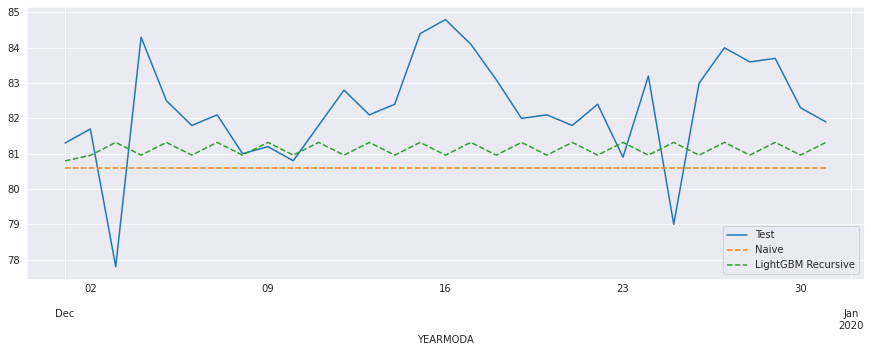

In [16]:
forecast_naive = naivef(ts_train, h=test_size)

print('     Naive MAE: %.4f Celsius' % mae(ts_test, forecast_naive))
print('  LightGBM MAE: %.4f Celsius' % mae(ts_test, forecast_recursive))

ax = ts_test.plot(figsize=(15,5), label='Test')
plt.plot(ts_test.index, forecast_naive, linestyle = '--', label='Naive')
plt.plot(ts_test.index, forecast_recursive, linestyle = '--', label='LightGBM Recursive')
ax.autoscale()
ax.legend()
plt.show()

<b>IMPORTANT NOTE:</b> We have to re-optimize the window size, since this is a new inference task.

#### Direct Forecasting

In direct forecasting, we train $n$ independent models and generate a multi-step forecast by concatenating the $n$ predictions.

For this implementation, we need to create a new $(X,Y)$ dataset, where $Y$ is now a vector of $n$ values.

In [17]:
w = 62
h = 31
test_size = 31
target = ['TEMP']
features = ['TEMP']

df_train, df_test = train_test_split(df_sample, w, h, test_size, features)

train_x, train_y = create_xy(df_train, target[0], w, h, shuffle=False)
test_x, test_y = create_xy(df_test, target[0], w, h, shuffle=False)

train_x = train_x.reshape((train_x.shape[0], train_x.shape[1]*train_x.shape[2]))
test_x = test_x.reshape((test_x.shape[0], test_x.shape[1]*test_x.shape[2]))

     Train X Shape: (242, 62)
     Train Y Shape: (242, 31)
      Test X Shape: (1, 62)
      Test Y Shape: (1, 31)


In [18]:
from sklearn.multioutput import MultiOutputRegressor

model = MultiOutputRegressor(lgb.LGBMRegressor(), n_jobs = -1)

model.fit(train_x, train_y)

MultiOutputRegressor(estimator=LGBMRegressor(), n_jobs=-1)

In [19]:
forecast_direct = model.predict(test_x).ravel()

               Naive MAE: 1.9387 Celsius
  LightGBM Recursive MAE: 1.5482 Celsius
     LightGBM Direct MAE: 1.2419 Celsius


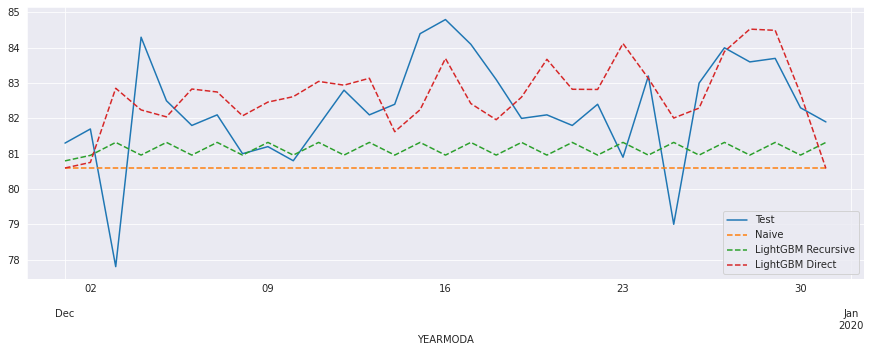

In [20]:
print('               Naive MAE: %.4f Celsius' % mae(ts_test, forecast_naive))
print('  LightGBM Recursive MAE: %.4f Celsius' % mae(ts_test, forecast_recursive))
print('     LightGBM Direct MAE: %.4f Celsius' % mae(ts_test, forecast_direct))

ax = ts_test.plot(figsize=(15,5), label='Test')
plt.plot(ts_test.index, forecast_naive, linestyle = '--', label='Naive')
plt.plot(ts_test.index, forecast_recursive, linestyle = '--', label='LightGBM Recursive')
plt.plot(ts_test.index, forecast_direct, linestyle = '--', label='LightGBM Direct')
ax.autoscale()
ax.legend()
plt.show()

<b>IMPORTANT NOTE:</b> Again, we have to re-optimize the window size, since this is a new inference task!

#### Single-Shot Forecasting

In single-shot forecasting, we create a model that attempts to predict all $n$-steps simultaneously.

Note that `LightGBM` does not support multi-output. Neural network models do however!

In [21]:
w = 62
h = 31
test_size = 31
target = ['TEMP']
features = ['TEMP']

df_train, df_test = train_test_split(df_sample, w, h, test_size, features)

### NORMALIZE ###
train_mean = df_train.mean().to_numpy()
train_std = df_train.std().to_numpy()
df_train = (df_train - train_mean)/train_std
df_test = (df_test - train_mean)/train_std

train_x, train_y = create_xy(df_train, target[0], w, h, shuffle=False)
test_x, test_y = create_xy(df_test, target[0], w, h, shuffle=False)

train_x = train_x.reshape((train_x.shape[0], train_x.shape[1]*train_x.shape[2]))
test_x = test_x.reshape((test_x.shape[0], test_x.shape[1]*test_x.shape[2]))

In [22]:
import tensorflow as tf

tf.keras.backend.clear_session()
tf.random.set_seed(1)

model = tf.keras.models.Sequential([                                                    
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(test_size)
])

model.compile(
    loss='mean_absolute_error',
    optimizer=tf.keras.optimizers.Adam())

history = model.fit(
    train_x, train_y, 
    epochs=5, 
    batch_size=1,
    verbose=1,
    validation_split=0.2)

Epoch 1/5
193/193 [==============================] - 2s 5ms/step - loss: 0.9554 - val_loss: 0.6998
Epoch 2/5
193/193 [==============================] - 0s 2ms/step - loss: 0.6965 - val_loss: 0.7174
Epoch 3/5
193/193 [==============================] - 0s 3ms/step - loss: 0.6492 - val_loss: 0.7363
Epoch 4/5
193/193 [==============================] - 0s 2ms/step - loss: 0.5851 - val_loss: 0.7450
Epoch 5/5
193/193 [==============================] - 0s 2ms/step - loss: 0.5679 - val_loss: 0.7656


In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (1, 32)                   2016      
_________________________________________________________________
dense_1 (Dense)              (1, 31)                   1023      
Total params: 3,039
Trainable params: 3,039
Non-trainable params: 0
_________________________________________________________________


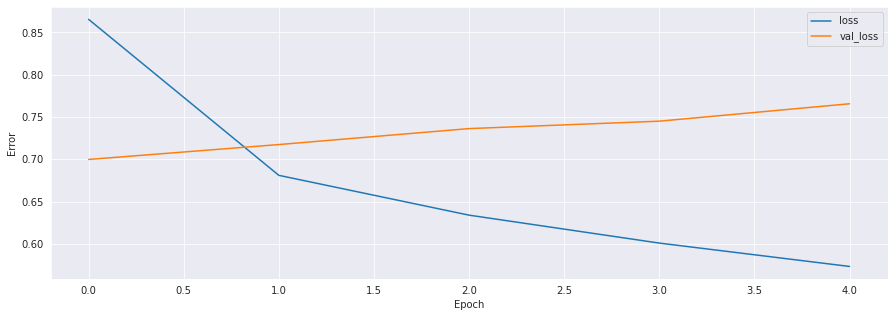

In [24]:
fig, ax = plt.subplots(figsize=(15,5))  
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.legend()
plt.show()

In [25]:
forecast_nn = model.predict(test_x).ravel()*train_std + train_mean # Reverse transform

In [26]:
ts_train

YEARMODA
2019-01-01    78.2
2019-01-02    81.4
2019-01-03    80.6
2019-01-04    82.2
2019-01-05    81.1
              ... 
2019-11-26    82.0
2019-11-27    83.9
2019-11-28    84.0
2019-11-29    81.2
2019-11-30    80.6
Name: TEMP, Length: 334, dtype: float64

               Naive MAE: 1.9387 Celsius
  LightGBM Recursive MAE: 1.5482 Celsius
     LightGBM Direct MAE: 1.2419 Celsius
     MLP Single-Shot MAE: 1.3690 Celsius


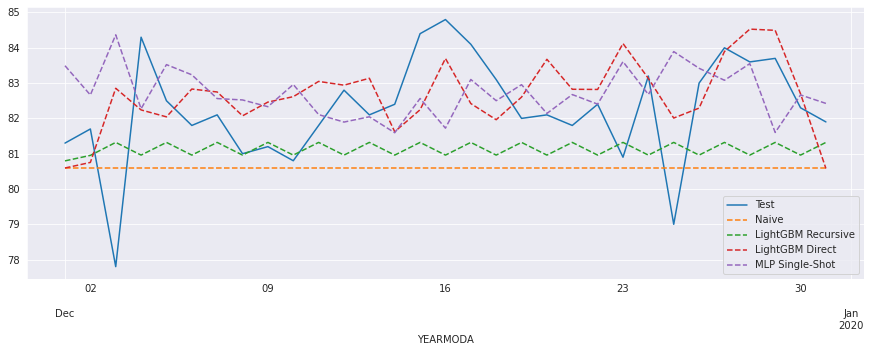

In [27]:
print('               Naive MAE: %.4f Celsius' % mae(ts_test, forecast_naive))
print('  LightGBM Recursive MAE: %.4f Celsius' % mae(ts_test, forecast_recursive))
print('     LightGBM Direct MAE: %.4f Celsius' % mae(ts_test, forecast_direct))
print('     MLP Single-Shot MAE: %.4f Celsius' % mae(ts_test, forecast_nn))

ax = ts_test.plot(figsize=(15,5), label='Test')
plt.plot(ts_test.index, forecast_naive, linestyle = '--', label='Naive')
plt.plot(ts_test.index, forecast_recursive, linestyle = '--', label='LightGBM Recursive')
plt.plot(ts_test.index, forecast_direct, linestyle = '--', label='LightGBM Direct')
plt.plot(ts_test.index, forecast_nn, linestyle = '--', label='MLP Single-Shot')
ax.autoscale()
ax.legend()
plt.show()

### Forecasting with Exogenous Variables

One of the benefits of taking a regression approach to time series forecasting is that it is relatively straight forward to add more predictors to the model.

Let's see if we can improve the forecast accuracy of the LightGBM with direct forecasting by adding exogenous variables.

In [62]:
w = 62
h = 31
test_size = 31
target = ['TEMP']
features = ['TEMP', 'MIN']
#features = ['TEMP', 'MAX', 'MIN', 'WDSP', 'MXSPD', 'PRCP']

df_train, df_test = train_test_split(df_sample, w, h, test_size, features)

train_x, train_y = create_xy(df_train, target[0], w, h, shuffle=False)
test_x, test_y = create_xy(df_test, target[0], w, h, shuffle=False)

train_x = train_x.reshape((train_x.shape[0], train_x.shape[1]*train_x.shape[2]))
test_x = test_x.reshape((test_x.shape[0], test_x.shape[1]*test_x.shape[2]))

print('     Train X Shape:', train_x.shape)
print('     Train Y Shape:', train_y.shape)

print('      Test X Shape:', test_x.shape)
print('      Test Y Shape:', test_y.shape)

     Train X Shape: (242, 124)
     Train Y Shape: (242, 31)
      Test X Shape: (1, 124)
      Test Y Shape: (1, 31)


In [63]:
model = MultiOutputRegressor(lgb.LGBMRegressor(), n_jobs = -1)

model.fit(train_x, train_y)

MultiOutputRegressor(estimator=LGBMRegressor(), n_jobs=-1)

In [64]:
forecast_direct_m = model.predict(test_x).ravel()

     LightGBM Direct Uni MAE: 1.2419 Celsius
     LightGBM Direct Mul MAE: 1.2007 Celsius


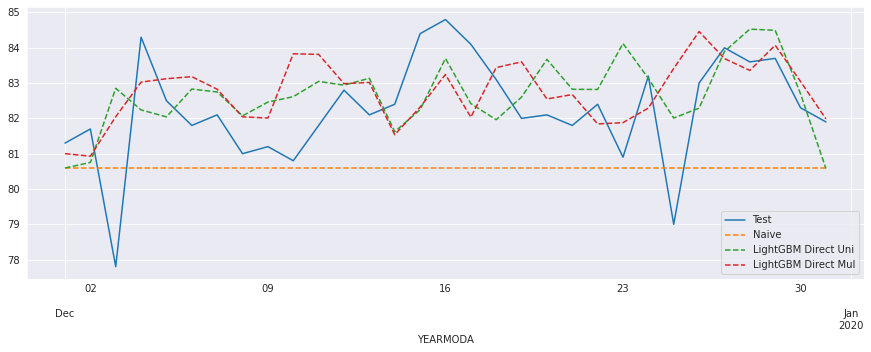

In [65]:
print('     LightGBM Direct Uni MAE: %.4f Celsius' % mae(ts_test, forecast_direct))
print('     LightGBM Direct Mul MAE: %.4f Celsius' % mae(ts_test, forecast_direct_m))

ax = ts_test.plot(figsize=(15,5), label='Test')
plt.plot(ts_test.index, forecast_naive, linestyle = '--', label='Naive')
plt.plot(ts_test.index, forecast_direct, linestyle = '--', label='LightGBM Direct Uni')
plt.plot(ts_test.index, forecast_direct_m, linestyle = '--', label='LightGBM Direct Mul')
ax.autoscale()
ax.legend()
plt.show()